In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys

# use the latest inference_interface to allow 1d hist!
# sys.path.insert(0,"/home/yuem/xenon_package/inference_interface")
from inference_interface import multihist_to_template, template_to_multihist
from alea.utils import get_file_path
from alea.models import BlueiceExtendedModel

In [2]:
import inference_interface

inference_interface.__file__

'/home/yuem/xenon_package/inference_interface/inference_interface.py'

In [3]:
example_model_config_path = get_file_path("unbinned_ces_simple.yaml")
example_model = BlueiceExtendedModel.from_config(example_model_config_path)

Computing/loading models on one core: 100%|██████████| 9/9 [00:00<00:00, 710.59it/s]


In [4]:
example_model.get_expectation_values()

{'test_flat': 1000.0, 'test_gaussian': 300.0, 'xe133': 1000.0009022263949}

In [5]:
source_name_list = example_model.get_source_name_list(likelihood_name="science_run_0")
source_name_list

['xe133', 'test_flat', 'test_gaussian']

### Simulate some data

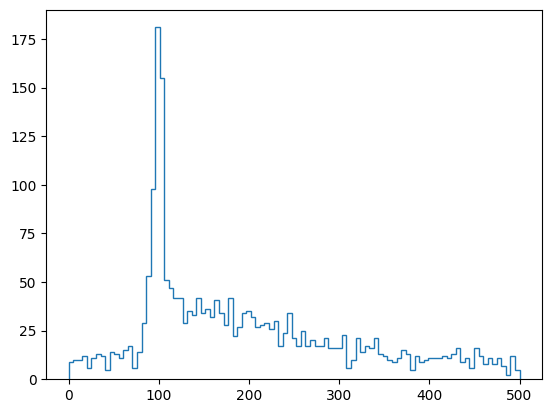

In [6]:
data = example_model.generate_data()
example_model.data = data
plt.hist(data["science_run_0"]["ces"], bins=np.linspace(0, 500, 100), histtype="step")
plt.show()

In [7]:
best_fit, max_ll = example_model.fit()
best_fit

{'livetime': 365.0,
 'xe133_rate_multiplier': 954.5282024030253,
 'test_flat_rate_multiplier': 990.8806994459104,
 'test_gaussian_rate_multiplier': 334.55402196394465,
 'smearing_a': 24.87126096348991,
 'smearing_b': 1.4629200940823672}

# Find the fitted smearing model

In [8]:
# unconstrained fit
from tqdm import tqdm

best_fit, ll_val = example_model.fit()

# constrained fits
a_vals = np.linspace(24.2, 25.2, 10)
b_vals = np.linspace(1.3, 1.6, 10)

ll_vals_c = np.zeros((len(a_vals), len(b_vals)))

for i, a in tqdm(enumerate(a_vals)):
    for j, b in enumerate(b_vals):
        _, ll_val_c = example_model.fit(smearing_a=a, smearing_b=b)
        ll_vals_c[i, j] = ll_val_c

10it [00:13,  1.35s/it]


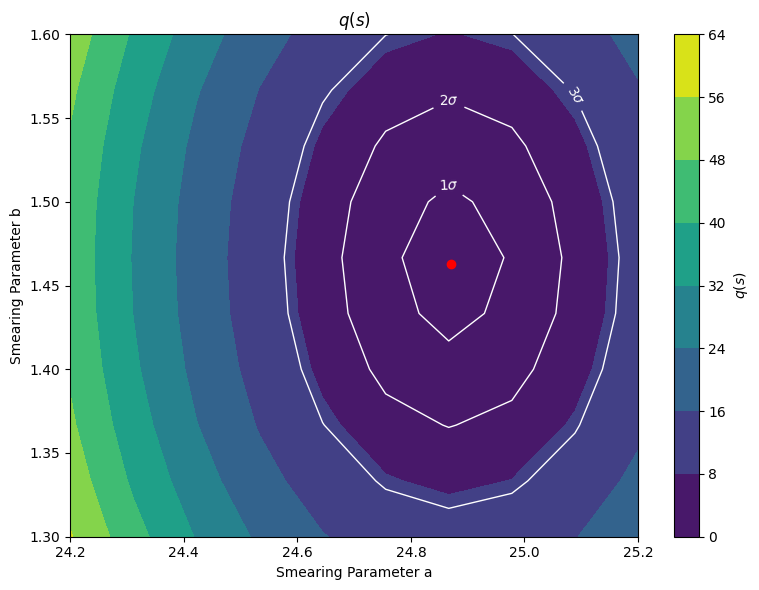

In [9]:
plt.figure(figsize=(8, 6))
plt.contourf(a_vals, b_vals, 2 * (ll_val - ll_vals_c).T, cmap="viridis")
plt.colorbar(label="$q(s)$")

contours = plt.contour(
    a_vals, b_vals, 2 * (ll_val - ll_vals_c).T, colors="white", linewidths=1, levels=[1, 4, 9]
)
sigma_levels = {1: r"1$\sigma$", 4: r"2$\sigma$", 9: r"3$\sigma$"}
plt.clabel(contours, inline=True, fontsize=10, fmt=sigma_levels)

plt.scatter(best_fit["smearing_a"], best_fit["smearing_b"], color="red")
plt.xlabel("Smearing Parameter a")
plt.ylabel("Smearing Parameter b")
plt.title("$q(s)$")
plt.tight_layout()
plt.show()